# Machine Learning Engineer Nanodegree
## Supervised Learning
## Project: Finding Donors for *CharityML*

Welcome to the second project of the Machine Learning Engineer Nanodegree! In this notebook, some template code has already been provided for you, and it will be your job to implement the additional functionality necessary to successfully complete this project. Sections that begin with **'Implementation'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section and the specifics of the implementation are marked in the code block with a `'TODO'` statement. Please be sure to read the instructions carefully!

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.  

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

## Getting Started

In this project, you will employ several supervised algorithms of your choice to accurately model individuals' income using data collected from the 1994 U.S. Census. You will then choose the best candidate algorithm from preliminary results and further optimize this algorithm to best model the data. Your goal with this implementation is to construct a model that accurately predicts whether an individual makes more than $50,000. This sort of task can arise in a non-profit setting, where organizations survive on donations.  Understanding an individual's income can help a non-profit better understand how large of a donation to request, or whether or not they should reach out to begin with.  While it can be difficult to determine an individual's general income bracket directly from public sources, we can (as we will see) infer this value from other publically available features. 

The dataset for this project originates from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Census+Income). The datset was donated by Ron Kohavi and Barry Becker, after being published in the article _"Scaling Up the Accuracy of Naive-Bayes Classifiers: A Decision-Tree Hybrid"_. You can find the article by Ron Kohavi [online](https://www.aaai.org/Papers/KDD/1996/KDD96-033.pdf). The data we investigate here consists of small changes to the original dataset, such as removing the `'fnlwgt'` feature and records with missing or ill-formatted entries.

----
## Exploring the Data
Run the code cell below to load necessary Python libraries and load the census data. Note that the last column from this dataset, `'income'`, will be our target label (whether an individual makes more than, or at most, $50,000 annually). All other columns are features about each individual in the census database.

In [2]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from time import time
from IPython.display import display # Allows the use of display() for DataFrames

# Set numpy seed value for reproducible results
np.random.seed(1487521041)

# Import supplementary visualization code visuals.py
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

# Load the Census dataset
data = pd.read_csv("census.csv")

# Success - Display the first record
display(data.head(n=1))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K


### Implementation: Data Exploration
A cursory investigation of the dataset will determine how many individuals fit into either group, and will tell us about the percentage of these individuals making more than \$50,000. In the code cell below, you will need to compute the following:
- The total number of records, `'n_records'`
- The number of individuals making more than \$50,000 annually, `'n_greater_50k'`.
- The number of individuals making at most \$50,000 annually, `'n_at_most_50k'`.
- The percentage of individuals making more than \$50,000 annually, `'greater_percent'`.

**Hint:** You may need to look at the table above to understand how the `'income'` entries are formatted. 

In [3]:
# TODO: Total number of records
n_records = data.shape[0]

# TODO: Number of records where individual's income is more than $50,000
n_greater_50k = data[data['income'] == '>50K'].shape[0]

# TODO: Number of records where individual's income is at most $50,000
n_at_most_50k = data[data['income'] == '<=50K'].shape[0]

# TODO: Percentage of individuals whose income is more than $50,000
greater_percent = n_greater_50k/float(n_records)*100

# Print the results
print "Total number of records: {}".format(n_records)
print "Individuals making more than $50,000: {}".format(n_greater_50k)
print "Individuals making at most $50,000: {}".format(n_at_most_50k)
print "Percentage of individuals making more than $50,000: {:.2f}%".format(greater_percent)

Total number of records: 45222
Individuals making more than $50,000: 11208
Individuals making at most $50,000: 34014
Percentage of individuals making more than $50,000: 24.78%


----
## Preparing the Data
Before data can be used as input for machine learning algorithms, it often must be cleaned, formatted, and restructured — this is typically known as **preprocessing**. Fortunately, for this dataset, there are no invalid or missing entries we must deal with, however, there are some qualities about certain features that must be adjusted. This preprocessing can help tremendously with the outcome and predictive power of nearly all learning algorithms.

### Transforming Skewed Continuous Features
A dataset may sometimes contain at least one feature whose values tend to lie near a single number, but will also have a non-trivial number of vastly larger or smaller values than that single number.  Algorithms can be sensitive to such distributions of values and can underperform if the range is not properly normalized. With the census dataset two features fit this description: '`capital-gain'` and `'capital-loss'`. 

Run the code cell below to plot a histogram of these two features. Note the range of the values present and how they are distributed.

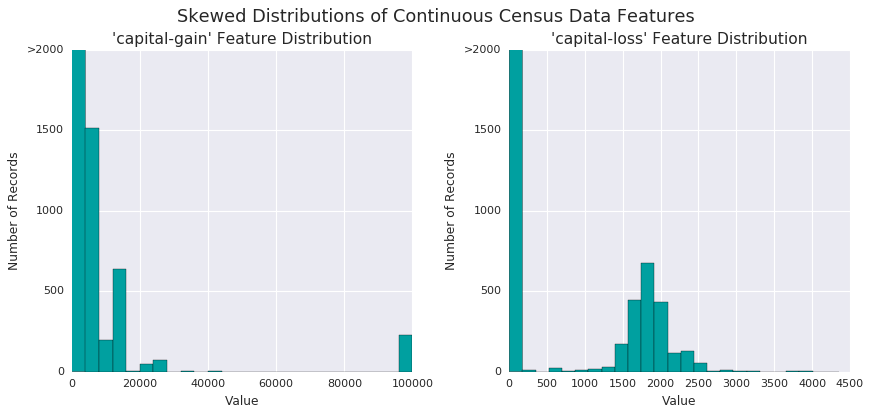

In [4]:
# Split the data into features and target label
income_raw = data['income']
features_raw = data.drop('income', axis = 1)

# Visualize skewed continuous features of original data
vs.distribution(data)

For highly-skewed feature distributions such as `'capital-gain'` and `'capital-loss'`, it is common practice to apply a <a href="https://en.wikipedia.org/wiki/Data_transformation_(statistics)">logarithmic transformation</a> on the data so that the very large and very small values do not negatively affect the performance of a learning algorithm. Using a logarithmic transformation significantly reduces the range of values caused by outliers. Care must be taken when applying this transformation however: The logarithm of `0` is undefined, so we must translate the values by a small amount above `0` to apply the the logarithm successfully.

Run the code cell below to perform a transformation on the data and visualize the results. Again, note the range of values and how they are distributed. 

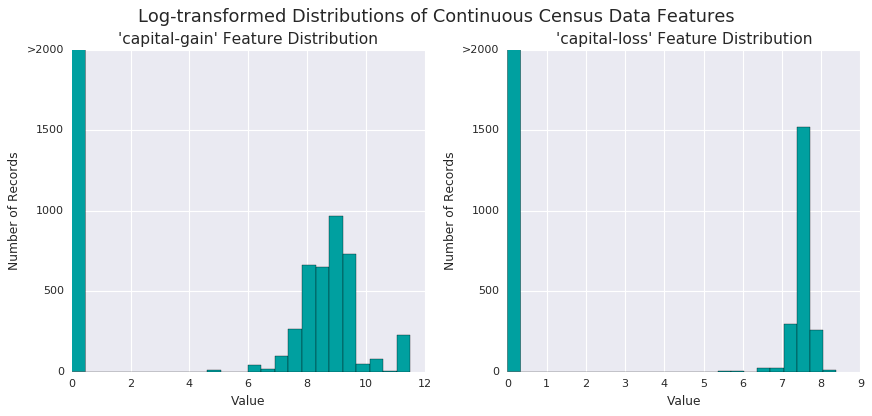

In [5]:
# Log-transform the skewed features
skewed = ['capital-gain', 'capital-loss']
features_raw[skewed] = data[skewed].apply(lambda x: np.log(x + 1))

# Visualize the new log distributions
vs.distribution(features_raw, transformed = True)

### Normalizing Numerical Features
In addition to performing transformations on features that are highly skewed, it is often good practice to perform some type of scaling on numerical features. Applying a scaling to the data does not change the shape of each feature's distribution (such as `'capital-gain'` or `'capital-loss'` above); however, normalization ensures that each feature is treated equally when applying supervised learners. Note that once scaling is applied, observing the data in its raw form will no longer have the same original meaning, as exampled below.

Run the code cell below to normalize each numerical feature. We will use [`sklearn.preprocessing.MinMaxScaler`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) for this.

In [6]:
# Import sklearn.preprocessing.StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler()
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
features_raw[numerical] = scaler.fit_transform(data[numerical])

# Show an example of a record with scaling applied
display(features_raw.head(n = 1))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.30137,State-gov,Bachelors,0.8,Never-married,Adm-clerical,Not-in-family,White,Male,0.02174,0.0,0.397959,United-States


### Implementation: Data Preprocessing

From the table in **Exploring the Data** above, we can see there are several features for each record that are non-numeric. Typically, learning algorithms expect input to be numeric, which requires that non-numeric features (called *categorical variables*) be converted. One popular way to convert categorical variables is by using the **one-hot encoding** scheme. One-hot encoding creates a _"dummy"_ variable for each possible category of each non-numeric feature. For example, assume `someFeature` has three possible entries: `A`, `B`, or `C`. We then encode this feature into `someFeature_A`, `someFeature_B` and `someFeature_C`.

|   | someFeature |                    | someFeature_A | someFeature_B | someFeature_C |
| :-: | :-: |                            | :-: | :-: | :-: |
| 0 |  B  |  | 0 | 1 | 0 |
| 1 |  C  | ----> one-hot encode ----> | 0 | 0 | 1 |
| 2 |  A  |  | 1 | 0 | 0 |

Additionally, as with the non-numeric features, we need to convert the non-numeric target label, `'income'` to numerical values for the learning algorithm to work. Since there are only two possible categories for this label ("<=50K" and ">50K"), we can avoid using one-hot encoding and simply encode these two categories as `0` and `1`, respectively. In code cell below, you will need to implement the following:
 - Use [`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies) to perform one-hot encoding on the `'features_raw'` data.
 - Convert the target label `'income_raw'` to numerical entries.
   - Set records with "<=50K" to `0` and records with ">50K" to `1`.

In [7]:
# One-hot encode the 'features_raw' data using pandas.get_dummies()
features = pd.get_dummies(features_raw)

# Encode the 'income_raw' data to numerical values
income = income_raw.apply(lambda x: 0 if x == "<=50K" else 1)

# Print the number of features after one-hot encoding
encoded = list(features.columns)
print "{} total features after one-hot encoding.".format(len(encoded))

103 total features after one-hot encoding.


### Shuffle and Split Data
Now all _categorical variables_ have been converted into numerical features, and all numerical features have been normalized. As always, we will now split the data (both features and their labels) into training and test sets. 80% of the data will be used for training and 20% for testing.

Run the code cell below to perform this split.

In [8]:
# Import train_test_split
from sklearn.cross_validation import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, income, test_size = 0.2, random_state = 42)

# Show the results of the split
print "Training set has {} samples.".format(X_train.shape[0])
print "Testing set has {} samples.".format(X_test.shape[0])

Training set has 36177 samples.
Testing set has 9045 samples.


----
## Evaluating Model Performance
In this section, we will investigate four different algorithms, and determine which is best at modeling the data. Three of these algorithms will be supervised learners of your choice, and the fourth algorithm is known as a *naive predictor*.

### Metrics and the Naive Predictor
*CharityML*, equipped with their research, knows individuals that make more than \$50,000 are most likely to donate to their charity. Because of this, *CharityML* is particularly interested in predicting who makes more than \$50,000 accurately. It would seem that using **accuracy** as a metric for evaluating a particular model's performace would be appropriate. Additionally, identifying someone that *does not* make more than \$50,000 as someone who does would be detrimental to *CharityML*, since they are looking to find individuals willing to donate. Therefore, a model's ability to precisely predict those that make more than \$50,000 is *more important* than the model's ability to **recall** those individuals. We can use **F-beta score** as a metric that considers both precision and recall:

$$ F_{\beta} = (1 + \beta^2) \cdot \frac{precision \cdot recall}{\left( \beta^2 \cdot precision \right) + recall} $$

In particular, when $\beta = 0.5$, more emphasis is placed on precision. This is called the **F$_{0.5}$ score** (or F-score for simplicity).

Looking at the distribution of classes (those who make at most \$50,000, and those who make more), it's clear most individuals do not make more than \$50,000. This can greatly affect **accuracy**, since we could simply say *"this person does not make more than \$50,000"* and generally be right, without ever looking at the data! Making such a statement would be called **naive**, since we have not considered any information to substantiate the claim. It is always important to consider the *naive prediction* for your data, to help establish a benchmark for whether a model is performing well. That been said, using that prediction would be pointless: If we predicted all people made less than \$50,000, *CharityML* would identify no one as donors. 

### Question 1 - Naive Predictor Performace
*If we chose a model that always predicted an individual made more than \$50,000, what would that model's accuracy and F-score be on this dataset?*  
**Note:** You must use the code cell below and assign your results to `'accuracy'` and `'fscore'` to be used later.

In [9]:
from sklearn import metrics

def accuracy_function(y_true, y_pred):
  return metrics.accuracy_score(y_true, y_pred)

def score_function(y_true, y_pred, beta=0.5):
  beta_squared = 0.5**2
  precision = metrics.precision_score(y_true, y_pred)
  recall = metrics.recall_score(y_true, y_pred)
  return (1+beta_squared**2)*precision*recall/(beta_squared*precision + recall)

# Naive Predictor is a classifier that predicts classes according to the distribution present in the training set.
# You can optionally define a probability yourself.
class NaivePredictor:
    classes = []
    probs = []
    
    def fit(self,x,y, probs=None):
      self.probs = probs
      self.classes, probs = np.unique(y, return_counts=True)
      if probs is None:
        self.probs = probs/float(len(y))
      return
    
    def predict(self,x):
      return np.random.choice(self.classes, size=x.shape[0], p=self.probs)

naive = NaivePredictor()
naive.fit(features,income, probs=[0,1]) # predict everyone as a donor
predicted = naive.predict(features)
  
# Calculate accuracy
accuracy = accuracy_function(income, predicted)

# Calculate F-score using the formula above for beta = 0.5
fscore = score_function(income, predicted)

# Print the results 
print "Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore)

# Out of curiosity, let's check out how a balanced random predictor would perform on this dataset.
        
not_that_naive = NaivePredictor()
not_that_naive.fit(features,income)
predicted = not_that_naive.predict(features)
        
accuracy = accuracy_function(income, predicted)
fscore = score_function(income, predicted)

# Print the results 
print "Balanced Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore)

# As expected, accuraccy goes up because we're getting more examples right
# but our F-score goes down because we're probably getting false negatives, that is
# marking possible donors as non donors

Naive Predictor: [Accuracy score: 0.2478, F-score: 0.2480]
Balanced Predictor: [Accuracy score: 0.5006, F-score: 0.2346]


###  Supervised Learning Models
**The following supervised learning models are currently available in** [`scikit-learn`](http://scikit-learn.org/stable/supervised_learning.html) **that you may choose from:**
- Gaussian Naive Bayes (GaussianNB)
- Decision Trees
- Ensemble Methods (Bagging, AdaBoost, Random Forest, Gradient Boosting)
- K-Nearest Neighbors (KNeighbors)
- Stochastic Gradient Descent Classifier (SGDC)
- Support Vector Machines (SVM)
- Logistic Regression

### Question 2 - Model Application
List three of the supervised learning models above that are appropriate for this problem that you will test on the census data. For each model chosen
- *Describe one real-world application in industry where the model can be applied.* (You may need to do research for this — give references!)
- *What are the strengths of the model; when does it perform well?*
- *What are the weaknesses of the model; when does it perform poorly?*
- *What makes this model a good candidate for the problem, given what you know about the data?*

**Answer: **

Instead of choosing just three I decided I would learn the most from actually doins this exercise for all possible
models.

# Gaussian Naive Baiyes

A Gaussian Naive Baiyes is a special instance of a Naive Bayes classifier where the likelihood of the features is assumed to be Gaussian.

## Real-world application

[Lou et al.][1] used a Gaussian NB Classifier to create a new predictor for determination of the DNA-binding proteins based on the features composed of sequence, predicted solvent accessibility, predicted secondary structure, and evolutionary profiles. The result was a classifier more accurate than the ones that were currently available.
[Metsis et al.][3] compared Gaussian and other distribution types when classifying SPAM and not SPAM messages,

## Strenghts and weaknesses

In spite of their apparently over-simplified assumptions, naive Bayes classifiers have worked quite well in many real-world situations. [2][2] shows that classification errors are small in both completely independent features but also in functionally dependent features (which is surprising).

## Applicability to current problem

[2][2] states that binary variables which are not linearly separable impose a challenge for NB classifiers. It fails to learn an XOR function for example. Given that we have applied one-hot encoding to our data, and effectively created many binary variables this might be problematic as the basic assumption of Naive Bayes is that, given class, features are independent of one another.

# Decision Trees

## Real-world application

Y. X. Gu et al [3][3] applied Decision Trees to classify chinese character. They were able to obtain a classifier capable of achieving 99.5 accuracy on the test set.

## Strenghts and weaknesses

Decision trees are to understand and to interpret. Trees can be easily visualised and explained.
If a given situation is observable in a model, the explanation for the condition is easily explained by boolean logic. By contrast, in a black box model (e.g., in an artificial neural network), results may be more difficult to interpret.

Overfitting is a problem to consider. Decision-tree learners can create over-complex trees that do not generalise the data well. Mechanisms to prevent this such as pruning are necessary to avoid this problem.
Also, decision trees can be unstable because small variations in the data might result in a completely different tree being generated.
Decision tree learners create biased trees if some classes dominate. It is therefore recommended to balance the dataset prior to fitting with the decision tree.

## Applicability to current problem

Given our current requirements in terms of recall and precision, balancing the classes before training might be required.

# Ensemble Methods (Bagging, AdaBoost, Random Forest, Gradient Boosting)

## Real-world application

In [4][4], Souhaib Ben Taieb and Rob J Hyndman used Gradient Boosting to reach fifth place on a Kaggle competition that involved predicting hourly demand in electricity load.

## Strenghts and weaknesses

Ensemble methods are very attractive and very successful in practice because of its resistance to overfitting. Also, because it uses an ensemble of simple learners, it is capable of expressing very complex models. That is, there is no requirement on linear separability of the data.

The drawbacks of having multiple simple learners are increased computational cost of prediction and (in contrast to decision trees) losing the ability to explain decisions.

## Applicability to current problem

There is no hard requirement in terms of prediction time for this problem. If filtering a list of prospects takes a whole day, there won’t be much impact.
The lack of ability to explain decisions might be problematic in a real world situation.

# K-Nearest Neighbors (KNeighbors)

## Real-world application

Hector Franco-Lopez et al. [5][5] used kNN to estimate forest attributes from satellite imagery. Respecting certain constraints, the authors claimed that his non-parametric technique was superior to other parametrics ones.

## Strenghts and weaknesses

kNN being a non-parametric method, it is often successful in classification situations where the decision boundary is very irregular.

kNN requires a copy of entire data-set, which makes it unfeasible in big datasets. Given no improvements, the search for nearest neighbors is quadratic in respect to the number of samples. This can be offset with alternate searching algorithms.

## Applicability to current problem

Given that we are dealing with census data, our dataset is likely to grow far beyond the sample that we have right now which might pose an issue given the weaknesses of the kNN algorithm.

# Support Vector Machines (SVM)

## Real-world application

Terrence S. Furey et al[6][6] used support vector machines in an attempt to classify cancerous tissues.

## Strenghts and weaknesses

Although SVM is a linear model, it is capable of performing a non-linear classification using what is called the kernel trick, implicitly mapping their inputs into high-dimensional feature spaces.
As it tries to find a hyperplane that separates the input linearly, it will have trouble if the features are not properly scaled.

## Applicability to current problem

Scaling has already been taken care of so we should be ok.

# Logistic Regression

Linear model

## Real-world application
Iswar Das et al. [7][7] applied logistic regression to assess landslide susceptibility.

## Strenghts and weaknesses

Being a linear model, it assumes linear relationships between the dependent and independent variables.

## Applicability to current problem

The key assumption about the dependent variable (dichotomy) Logistic Regression Classifier makes is already satisfied by our data, but we have not investigated the linear assumption.

# Stochastic Gradient Descent Classifier (SGDC)

Stochastic Gradient Descent Classifiers are linear classifiers (like SVM, or logistic regression) that use Stochastic Gradient Descent to estimate its parameters. This means that it sacrifices some accuracy in terms of minimizing error for speed. In practice, SGD is very successful and is one the the foundations of the recent Deep Learning advances.

## Applicability to current problem

Given we do not have that many features, or even too much data, SGD might not be a necessity here. We can use the entire dataset to update models on regular Gradient Descent.


References:
* [1]: http://journals.plos.org/plosone/article?id=10.1371/journal.pone.0086703
* [2]:  https://www.researchgate.net/profile/Irina_Rish/publication/228845263_An_Empirical_Study_of_the_Naive_Bayes_Classifier/links/00b7d52dc3ccd8d692000000/An-Empirical-Study-of-the-Naive-Bayes-Classifier.pdf
* [3]: http://ieeexplore.ieee.org/abstract/document/4767349/
* [4]: http://www.robjhyndman.com/papers/kaggle-competition.pdf
* [5]: http://www.sciencedirect.com/science/article/pii/S0034425701002097
* [6]:  https://academic.oup.com/bioinformatics/article/16/10/906/223564/Support-vector-machine-classification-and
* [7]: http://www.sciencedirect.com/science/article/pii/S0169555X09003985

[1]: http://journals.plos.org/plosone/article?id=10.1371/journal.pone.0086703
[2]:  https://www.researchgate.net/profile/Irina_Rish/publication/228845263_An_Empirical_Study_of_the_Naive_Bayes_Classifier/links/00b7d52dc3ccd8d692000000/An-Empirical-Study-of-the-Naive-Bayes-Classifier.pdf
[3]: http://ieeexplore.ieee.org/abstract/document/4767349/
[4]: http://www.robjhyndman.com/papers/kaggle-competition.pdf
[5]: http://www.sciencedirect.com/science/article/pii/S0034425701002097
[6]:  https://academic.oup.com/bioinformatics/article/16/10/906/223564/Support-vector-machine-classification-and
[7]: http://www.sciencedirect.com/science/article/pii/S0169555X09003985

### Implementation - Creating a Training and Predicting Pipeline
To properly evaluate the performance of each model you've chosen, it's important that you create a training and predicting pipeline that allows you to quickly and effectively train models using various sizes of training data and perform predictions on the testing data. Your implementation here will be used in the following section.
In the code block below, you will need to implement the following:
 - Import `fbeta_score` and `accuracy_score` from [`sklearn.metrics`](http://scikit-learn.org/stable/modules/classes.html#sklearn-metrics-metrics).
 - Fit the learner to the sampled training data and record the training time.
 - Perform predictions on the test data `X_test`, and also on the first 300 training points `X_train[:300]`.
   - Record the total prediction time.
 - Calculate the accuracy score for both the training subset and testing set.
 - Calculate the F-score for both the training subset and testing set.
   - Make sure that you set the `beta` parameter!

In [10]:
import random

def accuracy_function(y_true, y_pred):
  return metrics.accuracy_score(y_true, y_pred)

def score_function(y_true, y_pred, beta=0.5):
  return metrics.fbeta_score(y_true, y_pred, beta=beta)

def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # TODO: Fit the learner to the training data using slicing with 'sample_size'
    start = time() # Get start time
    idx = np.random.choice(X_train.shape[0], sample_size, replace=False )
    learner = learner.fit(X_train.iloc[idx], y_train.iloc[idx])
    end = time() # Get end time
    
    # TODO: Calculate the training time
    results['train_time'] = end - start
        
    # TODO: Get the predictions on the test set,
    #       then get predictions on the first 300 training samples
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time() # Get end time
    
    # TODO: Calculate the total prediction time
    results['pred_time'] = end - start
            
    # TODO: Compute accuracy on the first 300 training samples
    results['acc_train'] = accuracy_function(y_train[:300], predictions_train)
        
    # TODO: Compute accuracy on test set
    results['acc_test'] = accuracy_function(y_test, predictions_test)
    
    # TODO: Compute F-score on the the first 300 training samples
    results['f_train'] = score_function(y_train[:300], predictions_train)
        
    # TODO: Compute F-score on the test set
    results['f_test'] = score_function(y_test, predictions_test)
       
    # Success
    print "{} trained on {} samples.".format(learner.__class__.__name__, sample_size)
        
    # Return the results
    return results

### Implementation: Initial Model Evaluation
In the code cell, you will need to implement the following:
- Import the three supervised learning models you've discussed in the previous section.
- Initialize the three models and store them in `'clf_A'`, `'clf_B'`, and `'clf_C'`.
  - Use a `'random_state'` for each model you use, if provided.
  - **Note:** Use the default settings for each model — you will tune one specific model in a later section.
- Calculate the number of records equal to 1%, 10%, and 100% of the training data.
  - Store those values in `'samples_1'`, `'samples_10'`, and `'samples_100'` respectively.

**Note:** Depending on which algorithms you chose, the following implementation may take some time to run!

In [11]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression

global_results = {}

# Calculate the number of samples for 1%, 10%, and 100% of the training data
samples_1 = int(.01*X_train.shape[0])
samples_10 = int(.1*X_train.shape[0])
samples_100 = X_train.shape[0]

def evaluate_classifiers(classifiers):
  results = {}
  for clf in classifiers:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
      results[clf_name][i] = \
      train_predict(clf, samples, X_train, y_train, X_test, y_test)


  vs.evaluate(results, accuracy, fscore)
  return results

GaussianNB trained on 361 samples.
GaussianNB trained on 3617 samples.
GaussianNB trained on 36177 samples.
LogisticRegression trained on 361 samples.
LogisticRegression trained on 3617 samples.
LogisticRegression trained on 36177 samples.


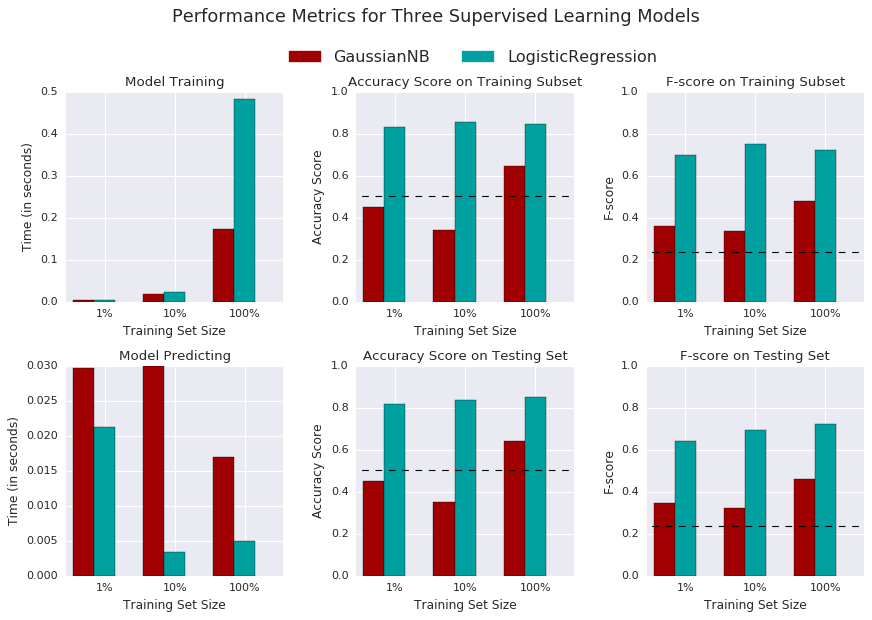

In [12]:
classifiers = [
    GaussianNB(),
    LogisticRegression(random_state=42)
]
global_results.update(evaluate_classifiers(classifiers))

/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


SVC trained on 361 samples.
SVC trained on 3617 samples.
SVC trained on 36177 samples.
DecisionTreeClassifier trained on 361 samples.
DecisionTreeClassifier trained on 3617 samples.
DecisionTreeClassifier trained on 36177 samples.
KNeighborsClassifier trained on 361 samples.
KNeighborsClassifier trained on 3617 samples.
KNeighborsClassifier trained on 36177 samples.


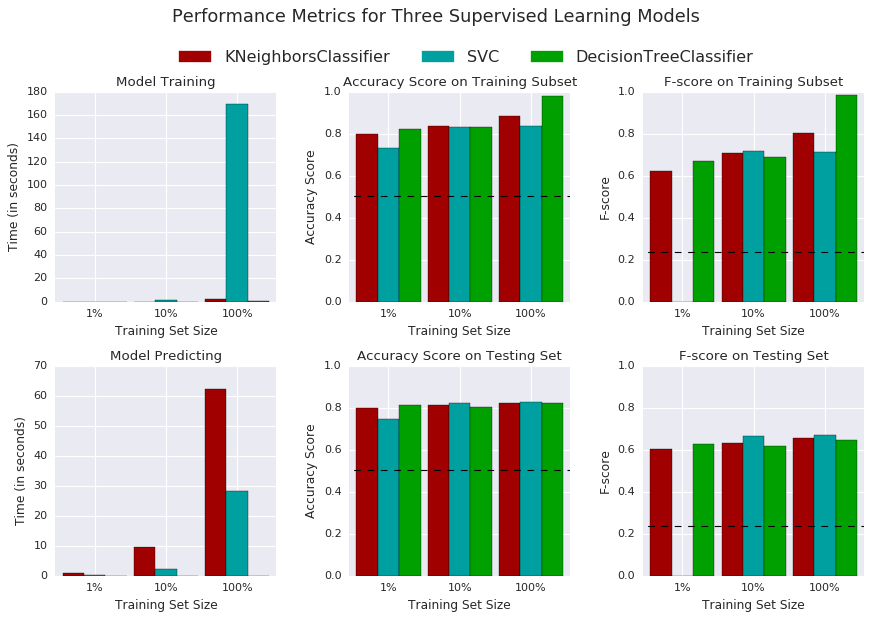

In [13]:
# non linear
classifiers = [
  SVC(random_state=42),
  DecisionTreeClassifier(random_state=42),
  KNeighborsClassifier()
]
global_results.update(evaluate_classifiers(classifiers))

RandomForestClassifier trained on 361 samples.
RandomForestClassifier trained on 3617 samples.
RandomForestClassifier trained on 36177 samples.
AdaBoostClassifier trained on 361 samples.
AdaBoostClassifier trained on 3617 samples.
AdaBoostClassifier trained on 36177 samples.


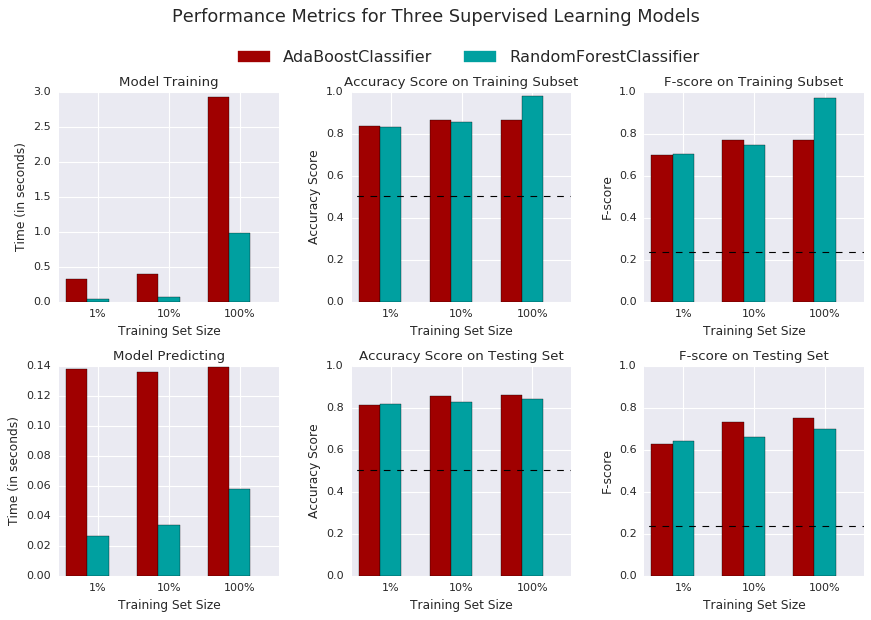

In [14]:
# ensemble
classifiers = [
  RandomForestClassifier(random_state=42),
  AdaBoostClassifier(random_state=42)
]
global_results.update(evaluate_classifiers(classifiers))

/usr/local/lib/python2.7/dist-packages/sklearn/discriminant_analysis.py:688: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


QuadraticDiscriminantAnalysis trained on 361 samples.
QuadraticDiscriminantAnalysis trained on 3617 samples.
QuadraticDiscriminantAnalysis trained on 36177 samples.
SGDClassifier trained on 361 samples.
SGDClassifier trained on 3617 samples.
SGDClassifier trained on 36177 samples.


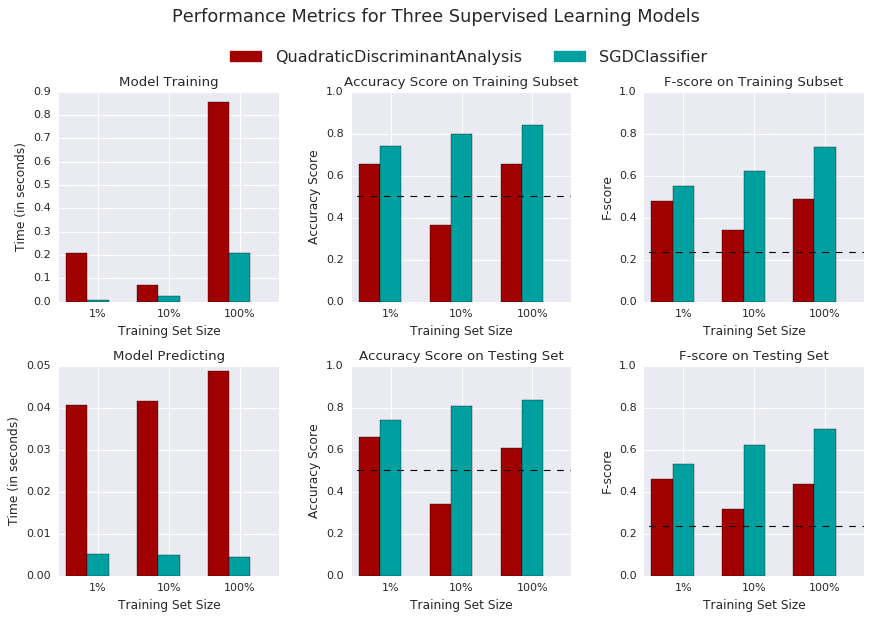

In [15]:
# the others
classifiers = [
  QuadraticDiscriminantAnalysis(),
  SGDClassifier()
]
global_results.update(evaluate_classifiers(classifiers))

In [16]:
df = pd.Panel.from_dict(global_results).to_frame().round(4)
display(df)

AdaBoostClassifier  DecisionTreeClassifier  GaussianNB  \
major      minor                                                           
acc_test   0                  0.8104                  0.8104      0.4504   
           1                  0.8549                  0.8050      0.3496   
           2                  0.8607                  0.8208      0.6396   
acc_train  0                  0.8367                  0.8200      0.4500   
           1                  0.8633                  0.8333      0.3433   
           2                  0.8667                  0.9800      0.6433   
f_test     0                  0.6274                  0.6272      0.3459   
           1                  0.7331                  0.6169      0.3235   
           2                  0.7491                  0.6480      0.4581   
f_train    0                  0.6983                  0.6684      0.3582   
           1                  0.7681                  0.6901      0.3356   
           2                  0.7703                  0.9843      0.4806   
pred_time  0                  0.1378                  0.0060      0.0297   
           1                  0.1357                  0.0077      0.0299   
           2                  0.1389                  0.0097      0.0169   
train_time 0                  0.3285                  0.0059      0.0043   
           1                  0.3902                  0.0451      0.0180   
           2                  2.9213                  0.8175      0.1731   

                  KNeighborsClassifier  LogisticRegression  \
major      minor                                             
acc_test   0                    0.7988              0.8158   
           1                    0.8124              0.8369   
           2                    0.8224              0.8503   
acc_train  0                    0.7967              0.8333   
           1                    0.8367              0.8533   
           2                    0.8833              0.8433   
f_test     0                    0.6035              0.6413   
           1                    0.6317              0.6931   
           2                    0.6553              0.7223   
f_train    0                    0.6234              0.7003   
           1                    0.7082              0.7508   
           2                    0.8033              0.7202   
pred_time  0                    0.8782              0.0212   
           1                    9.6660              0.0034   
           2                   62.2791              0.0050   
train_time 0                    0.0063              0.0050   
           1                    0.0457              0.0226   
           2                    2.2930              0.4818   

                  QuadraticDiscriminantAnalysis  RandomForestClassifier  \
major      minor                                                          
acc_test   0                             0.6608                  0.8163   
           1                             0.3400                  0.8250   
           2                             0.6094                  0.8423   
acc_train  0                             0.6567                  0.8300   
           1                             0.3667                  0.8533   
           2                             0.6567                  0.9800   
f_test     0                             0.4593                  0.6426   
           1                             0.3193                  0.6600   
           2                             0.4353                  0.6993   
f_train    0                             0.4769                  0.7009   
           1                             0.3418                  0.7450   
           2                             0.4904                  0.9698   
pred_time  0                             0.0407                  0.0265   
           1                             0.0414                  0.0338   
           2                             0.0488         

# DISCLAIMER:

We have just leaked test subset information into our model. Ideally we should use cross validation to perform checks like these to make sure  we do not compromise the test subset. By doing so we have chosen a model that already has some information on this particular testing set and might have problems generalizing to real data.

----
## Improving Results
In this final section, you will choose from the three supervised learning models the *best* model to use on the student data. You will then perform a grid search optimization for the model over the entire training set (`X_train` and `y_train`) by tuning at least one parameter to improve upon the untuned model's F-score. 

### Question 3 - Choosing the Best Model
*Based on the evaluation you performed earlier, in one to two paragraphs, explain to *CharityML* which of the three models you believe to be most appropriate for the task of identifying individuals that make more than \$50,000.*  
**Hint:** Your answer should include discussion of the metrics, prediction/training time, and the algorithm's suitability for the data.

**Answer: **

Of all the models chosen, ADABoost seems to be the most promising. ADABoost is in itself an interesting algorithm because of its overfitting resistance which we got to experience in these trial. While some algorithms like Decision Trees alone showed signs of overfitting, both accuracy and f-score kept going up as we added more data to training.
The model achieved the highest accuracy and f-score of all tested models, while both prediction and training times stayed really low.


### Question 4 - Describing the Model in Layman's Terms
*In one to two paragraphs, explain to *CharityML*, in layman's terms, how the final model chosen is supposed to work. Be sure that you are describing the major qualities of the model, such as how the model is trained and how the model makes a prediction. Avoid using advanced mathematical or technical jargon, such as describing equations or discussing the algorithm implementation.*

**Answer: ** 

Adaboost is an ensemble algorith, which mean it bases it's final decision on the multiple small decisions made by other classifiers.
To train a model like this we choose a base classifier, like a decision tree, and train it on the available data. Then, for the decisions this models gets wrong we train another another tree, but this time putting more weight, that is, emphasis on the wrong decisions. We repeat this a number of times until we reach an ensemble of small classifiers.
The prediction of a new unseen example is given by the weighted majority vote of the individual classifiers.

### Implementation: Model Tuning
Fine tune the chosen model. Use grid search (`GridSearchCV`) with at least one important parameter tuned with at least 3 different values. You will need to use the entire training set for this. In the code cell below, you will need to implement the following:
- Import [`sklearn.grid_search.GridSearchCV`](http://scikit-learn.org/0.17/modules/generated/sklearn.grid_search.GridSearchCV.html) and [`sklearn.metrics.make_scorer`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html).
- Initialize the classifier you've chosen and store it in `clf`.
 - Set a `random_state` if one is available to the same state you set before.
- Create a dictionary of parameters you wish to tune for the chosen model.
 - Example: `parameters = {'parameter' : [list of values]}`.
 - **Note:** Avoid tuning the `max_features` parameter of your learner if that parameter is available!
- Use `make_scorer` to create an `fbeta_score` scoring object (with $\beta = 0.5$).
- Perform grid search on the classifier `clf` using the `'scorer'`, and store it in `grid_obj`.
- Fit the grid search object to the training data (`X_train`, `y_train`), and store it in `grid_fit`.

**Note:** Depending on the algorithm chosen and the parameter list, the following implementation may take some time to run!

In [21]:
from sklearn.grid_search import GridSearchCV 
from sklearn.metrics import fbeta_score, make_scorer, accuracy_score


# Initialize the classifier
clf = AdaBoostClassifier(random_state=42, base_estimator=DecisionTreeClassifier())

# Create the parameters list you wish to tune
parameters = [
  {
    'n_estimators': [10,20,50,100, 150, 200],
    'base_estimator__max_depth': [None, 1, 2, 3, 5, 10]
  }
]

# Make an fbeta_score scoring object
scorer = make_scorer(fbeta_score, beta=0.5)

# Perform grid search on the classifier using 'scorer' as the scoring method
grid_obj = GridSearchCV(clf, parameters, scoring=scorer, verbose=1, n_jobs=16)

# TODO: Fit the grid search object to the training data and find the optimal parameters
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print "Unoptimized model\n------"
print "Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5))
print "\nOptimized Model\n------"
print "Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions))
print "Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5))

Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:  2.3min
[Parallel(n_jobs=16)]: Done 108 out of 108 | elapsed: 15.1min finished


Unoptimized model
------
Accuracy score on testing data: 0.8229
F-score on testing data: 0.6553

Optimized Model
------
Final accuracy score on the testing data: 0.8706
Final F-score on the testing data: 0.7643


In [20]:
grid_fit.best_params_

{'base_estimator__class_weight': None,
 'base_estimator__max_depth': 2,
 'n_estimators': 100}

### Question 5 - Final Model Evaluation
_What is your optimized model's accuracy and F-score on the testing data? Are these scores better or worse than the unoptimized model? How do the results from your optimized model compare to the naive predictor benchmarks you found earlier in **Question 1**?_  
**Note:** Fill in the table below with your results, and then provide discussion in the **Answer** box.

#### Results:

|     Metric     | Benchmark Predictor | Unoptimized Model | Optimized Model |
| :------------: | :-----------------: | :---------------: | :-------------: | 
| Accuracy Score | 0.2478              |   0.8229          | 0.8706          |
| F-score        | 0.2480              |   0.6553          | 0.7643          |


**Answer: **

Our final model improved accuracy by 5.7% and the F-score by 16.6%.
It is much better than our benchmark predictor, improving both metrics by a wide margin.

----
## Feature Importance

An important task when performing supervised learning on a dataset like the census data we study here is determining which features provide the most predictive power. By focusing on the relationship between only a few crucial features and the target label we simplify our understanding of the phenomenon, which is most always a useful thing to do. In the case of this project, that means we wish to identify a small number of features that most strongly predict whether an individual makes at most or more than \$50,000.

Choose a scikit-learn classifier (e.g., adaboost, random forests) that has a `feature_importance_` attribute, which is a function that ranks the importance of features according to the chosen classifier.  In the next python cell fit this classifier to training set and use this attribute to determine the top 5 most important features for the census dataset.

### Question 6 - Feature Relevance Observation
When **Exploring the Data**, it was shown there are thirteen available features for each individual on record in the census data.  
_Of these thirteen records, which five features do you believe to be most important for prediction, and in what order would you rank them and why?_

**Answer:**

### Implementation - Extracting Feature Importance
Choose a `scikit-learn` supervised learning algorithm that has a `feature_importance_` attribute availble for it. This attribute is a function that ranks the importance of each feature when making predictions based on the chosen algorithm.

In the code cell below, you will need to implement the following:
 - Import a supervised learning model from sklearn if it is different from the three used earlier.
 - Train the supervised model on the entire training set.
 - Extract the feature importances using `'.feature_importances_'`.

In [ ]:
# TODO: Import a supervised learning model that has 'feature_importances_'

# TODO: Train the supervised model on the training set 
model = None

# TODO: Extract the feature importances
importances = None

# Plot
vs.feature_plot(importances, X_train, y_train)

### Question 7 - Extracting Feature Importance

Observe the visualization created above which displays the five most relevant features for predicting if an individual makes at most or above \$50,000.  
_How do these five features compare to the five features you discussed in **Question 6**? If you were close to the same answer, how does this visualization confirm your thoughts? If you were not close, why do you think these features are more relevant?_

**Answer:**

### Feature Selection
How does a model perform if we only use a subset of all the available features in the data? With less features required to train, the expectation is that training and prediction time is much lower — at the cost of performance metrics. From the visualization above, we see that the top five most important features contribute more than half of the importance of **all** features present in the data. This hints that we can attempt to *reduce the feature space* and simplify the information required for the model to learn. The code cell below will use the same optimized model you found earlier, and train it on the same training set *with only the top five important features*. 

In [ ]:
# Import functionality for cloning a model
from sklearn.base import clone

# Reduce the feature space
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]

# Train on the "best" model found from grid search earlier
clf = (clone(best_clf)).fit(X_train_reduced, y_train)

# Make new predictions
reduced_predictions = clf.predict(X_test_reduced)

# Report scores from the final model using both versions of data
print "Final Model trained on full data\n------"
print "Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5))
print "\nFinal Model trained on reduced data\n------"
print "Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_predictions, beta = 0.5))

### Question 8 - Effects of Feature Selection
*How does the final model's F-score and accuracy score on the reduced data using only five features compare to those same scores when all features are used?*  
*If training time was a factor, would you consider using the reduced data as your training set?*

**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.